# Detect claims to fact check in political debates

In this project you will implement various classifiers using both neural and feature based technqiues to detect which sentences in political debates should be fact checked.
Dataset from ClaimBuster: https://zenodo.org/record/3609356 
Evaluate your classifiers using the same metrics as http://ranger.uta.edu/~cli/pubs/2017/claimbuster-kdd17-hassan.pdf (Table 2)

Classification report from sklearn provides everything

In [1]:
# TODO:  Create advanced model(s) (suggestions are given below)
#           -- Generate more features that a model can use. For example the context around the sentence, sentiment, named entities etc.
#           -- Rule based classifier. For example, if sentence contains certain words, tags, statistics etc.
#           -- Deep learning (word embeddings, transformer models etc.)
#           -- Sub-sentence classifier. Long sentences may include several claims, so the goal is to mark the span of claim(s) within a sentence

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import collections
import string

from sklearn.cluster import KMeans
from sklearn.metrics import *
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier

import json
import glob
import re
import time 

# Loading and merging the data

In [3]:
file1 = pd.read_csv("data/crowdsourced.csv", encoding='utf-8')
file2 = pd.read_csv("data/groundtruth.csv", encoding='utf-8')
df = pd.concat([file1, file2])


df["date"] = df["File_id"].str.strip(to_strip=".txt")

df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace= True)
df["mos_before_election"] = 11 - df["date"].dt.month

df['index'] = pd.RangeIndex(len(df))
df.set_index('index', inplace=True)
df


,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict,date,mos_before_election
index,,,,,,,,,,,,
0,8211,"Now, this is not standing still.",Richard M. Nixon,Vice President,REPUBLICAN,1960-09-26.txt,6,114,-0.417840,-1,1960-09-26,2
1,8515,So these are three programs which are quite mo...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,9,418,0.249581,-1,1960-09-26,2
2,8514,The proposal advanced by you and by Mr. Javits...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,42,417,-0.626563,1,1960-09-26,2
3,8513,It does not put a deficit on the Treasury.,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,9,416,-0.629486,1,1960-09-26,2
4,8512,The third is medical care for the aged which i...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,22,415,0.000000,-1,1960-09-26,2
...,...,...,...,...,...,...,...,...,...,...,...,...
23528,34028,"First of all, the media is so dishonest and so...",Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,17,907,0.032300,-1,2016-10-19,1
23529,34027,What I've seen -- what I've seen is so bad.,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,9,906,-0.669600,-1,2016-10-19,1
23530,34026,I'll look at it at the time.,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,7,905,0.000000,-1,2016-10-19,1


# Data preprocessing

In [4]:
def remove_punctuation(text):
    tokens = re.sub('[^a-zA-Z]', ' ', text).lower()
    return tokens

In [5]:
def remove_stop_words(text):
    stop_words = stopwords.words('english')
    word_list = [word for word in text.split() if word not in stop_words]
    return word_list

In [6]:
def get_word_stemm(word_list):
    """Stemmers remove morphological affixes from words, leaving only the word stem."""
    stemmer = SnowballStemmer('english')
    singles = [stemmer.stem(word) for word in word_list] 
    return singles

In [7]:
def preprocess_data(docs):

    text_list = [] 
    for doc in docs:  
        # 1. Remove punctuation and set as lower case
        text = remove_punctuation(doc)

        # 2. Remove stop words and extra spaces
        word_list = remove_stop_words(text)
        joined_text = " ".join(word_list)
        text_list.append(joined_text)
        
        # 3. Stemming
        # word_stem = get_word_stemm(word_list)
        # joined_text = " ".join(word_stem)
        # text_list.append(joined_text)


    return text_list



In [8]:
data = preprocess_data(df.Text.values)

In [9]:
# add clean text to dataframe
df["Clean_text"] = pd.Series(data)

In [10]:
del file1, file2, data

In [11]:
df.head()

,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict,date,mos_before_election,Clean_text
index,,,,,,,,,,,,,
0,8211,"Now, this is not standing still.",Richard M. Nixon,Vice President,REPUBLICAN,1960-09-26.txt,6,114,-0.417840,-1,1960-09-26,2,standing still
1,8515,So these are three programs which are quite mo...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,9,418,0.249581,-1,1960-09-26,2,three programs quite moderate
2,8514,The proposal advanced by you and by Mr. Javits...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,42,417,-0.626563,1,1960-09-26,2,proposal advanced mr javits would cost six hun...
3,8513,It does not put a deficit on the Treasury.,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,9,416,-0.629486,1,1960-09-26,2,put deficit treasury
4,8512,The third is medical care for the aged which i...,John F. Kennedy,Senator,DEMOCRAT,1960-09-26.txt,22,415,0.000000,-1,1960-09-26,2,third medical care aged tied social security f...


# Train-test split


In [12]:
mask = df["date"].dt.year < 2012

X_train = df.loc[mask, "Clean_text"].values
y_train = df.loc[mask, "Verdict"].values

X_test = df.loc[~mask, "Clean_text"].values
y_test = df.loc[~mask, "Verdict"].values

# TF-idf

vectorizer = TfidfVectorizer(max_df=0.6, stop_words='english')
X_train = vectorizer.fit_transform(X_train)
print("n_samples: %d, n_features: %d" % X_train.shape)
X_test = vectorizer.transform(X_test)
print("n_samples: %d, n_features: %d" % X_test.shape)

feature_names = vectorizer.get_feature_names_out()



# Base line model

1. SVM
2. KNN
3. Perceptron
4. Naive Bayes
5. Decision Tree 
5. Random Forest



import time 

def baseline(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    print("                       Classification report")
    report = classification_report(y_test, pred, target_names= ["NFS", "UFS", "CFS"])
    print(report)

    return {
            "score": score,
            "report": report, 
            "train_time": train_time, 
            "test_time": test_time, 
            }


results = {}

clfs = [
        ("SVM", svm.SVC(kernel='linear')), 
        ("KNN", KNeighborsClassifier(n_neighbors=10)), 
        ("Perceptron", Perceptron(max_iter=50)),
        ("NB", ComplementNB()),
        ("DT", DecisionTreeClassifier()),
        ("RF", RandomForestClassifier(min_samples_split=5))
        ]   

for classifier in clfs:
    result = baseline(classifier[1])  
    results.setdefault(classifier[0], result)


results.keys()

# Word Embedding using keras - NOT WORKING YET :D 

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

# Defining vocabulary size
vocabulary_size = list(unique_word_dict.values())[-1]

## One hot encoding representation

encoded_vocab = [one_hot(words, vocabulary_size) for words in df["Text_clean"].values]

## Padding sequences

# finding max sentence length

vec_lengths = []
for i in encoded_vocab:
    vec_lengths.append(len(i))


max_length = np.unique(vec_lengths)[-1]
max_length

embedded_docs=pad_sequences(encoded_vocab,padding='pre',maxlen=max_length)
print(embedded_docs)

model=Sequential()
model.add(Embedding(vocabulary_size,30,input_length=max_length))
model.compile('adam','mse')

model.summary()

model.predict_classes()

# Kurt's try - Classification with a BERT model

https://huggingface.co/docs/tokenizers/python/latest/components.html#models <br>
_One of the most popular subword tokenization algorithm. The Byte-Pair-Encoding works by starting with characters, while merging those that are the most frequently seen together, thus creating new tokens. It then works iteratively to build new tokens out of the most frequent pairs it sees in a corpus.BPE is able to build words it has never seen by using multiple subword tokens, and thus requires smaller vocabularies, with less chances of having “unk” (unknown) tokens._

James briggs, https://youtu.be/GYDFBfx8Ts8

Before encoding, we need to figure out how long each sequence to be because the encoder method also acts like a padding or truncation method. 

FYI: raw data:

<Figure size 864x720 with 0 Axes>

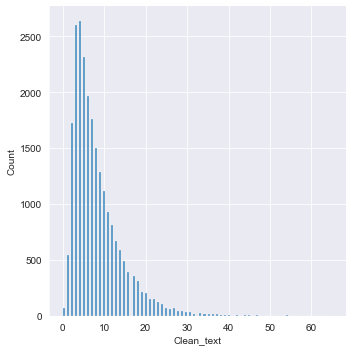

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

seqlen2 = df["Clean_text"].apply(lambda x: len(x.split()))
sns.set_style("darkgrid")
plt.figure(figsize = (12,10))
sns.displot(seqlen2)

Preprocessed data:

In [14]:
seqlen = pd.DataFrame(X_train, columns=["Clean_text"])["Clean_text"].apply(lambda x: len(x.split()))

<Figure size 864x720 with 0 Axes>

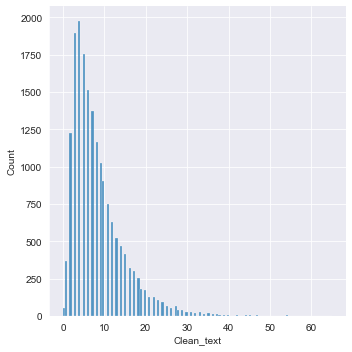

In [15]:
plt.figure(figsize = (12,10))
sns.set_style("darkgrid")
sns.displot(seqlen)

In [16]:
SEQ_LEN = 30

initialize tokenizer from a pretrained model. Since we have lowercase text, we use the uncased BERT.

In [18]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 4.65kB/s]
Downloading: 100%|██████████| 570/570 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 496kB/s] 
Downloading: 100%|██████████| 455k/455k [00:00<00:00, 1.08MB/s]


now that we have initiated the tokenizer, we can do the encoding. add each sequence into a numpy array:

In [19]:
import numpy as np
# initializing np arrays, length of df by the sequence length that is defined above

Xids = np.zeros((len(X_train), SEQ_LEN))
Xmask = np.zeros((len(X_train), SEQ_LEN))

for i, text in enumerate(X_train):
    tokens = tokenizer.encode_plus(text, 
        max_length = SEQ_LEN, 
        truncation = True, 
        padding = "max_length",
        add_special_tokens = True, 
        return_token_type_ids = False, 
        return_attention_mask = True, 
        return_tensors = "tf")
    Xids[i, :] = tokens["input_ids"]
    Xmask[i, :] = tokens["attention_mask"]

In [20]:
Xids

array([[  101.,  3061.,  2145., ...,     0.,     0.,     0.],
       [  101.,  2093.,  3454., ...,     0.,     0.,     0.],
       [  101.,  6378.,  3935., ...,     0.,     0.,     0.],
       ...,
       [  101.,  2228.,  4012., ...,     0.,     0.,     0.],
       [  101., 19821.,  2488., ...,     0.,     0.,     0.],
       [  101., 22395.,  2283., ...,     0.,     0.,     0.]])

In [21]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Do the same for testing data:

In [22]:
Xids_test = np.zeros((len(X_test), SEQ_LEN))
Xmask_test = np.zeros((len(X_test), SEQ_LEN))

for i, text in enumerate(X_test):
    tokens = tokenizer.encode_plus(text, 
        max_length = SEQ_LEN, 
        truncation = True, 
        padding = "max_length",
        add_special_tokens = True, 
        return_token_type_ids = False, 
        return_attention_mask = True, 
        return_tensors = "tf")
    Xids_test[i, :] = tokens["input_ids"]
    Xmask_test[i, :] = tokens["attention_mask"]

one-hot-encoding the labels

In [23]:
labels = np.zeros((y_train.size, len(np.unique(y_train))))
labels.shape

(18170, 3)

In [24]:
labels[np.arange(y_train.size), y_train] = 1
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

alternatively, using sk-learn:

In [25]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train.reshape(-1, 1))
y_encoded = one_hot_encoder.transform(y_train.reshape(-1, 1))
y_encoded = pd.DataFrame(data=y_encoded, columns=one_hot_encoder.categories_)


and for the test data:

In [26]:
labels_test = np.zeros((y_test.size, len(np.unique(y_test))))

labels_test[np.arange(y_test.size), y_test] = 1
labels_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [27]:
with open("xids.npy", "wb") as f:
    np.save(f, Xids)
with open("xmasks.npy", "wb") as f:
    np.save(f, Xmask)
with open("labels.npy", "wb") as f:
    np.save(f, labels)
with open("labels2.npy", "wb") as f:
    np.save(f, y_encoded)


# delete from memory    
# del df, Xids, Xmask, labels, y_encoded, X_train, X_test, y_train, y_test 

In [28]:
with open("xids.npy", "rb") as fp:
    Xids = np.load(fp)
with open("xmasks.npy", "rb") as fp:
    Xmask = np.load(fp)
with open("labels.npy", "rb") as fp:
    labels = np.load(fp)
with open("labels2.npy", "rb") as fp:
    y_encoded = np.load(fp)

In [29]:
import tensorflow as tf

In [30]:
tf.config.experimental.list_physical_devices("GPU")

[]

tensorflow dataset object: makes it a lot easier (restructure the data, shuffle and batch it in just a few lines of code) - faster in terms of performance and faster for us to code

 > restructure the data:

 tensorflow expect the data to be input as a tuple consisting of our input and target label. since we are using BERT, our data should be slightly different. input tuple  should be a dictionary containing an key that is input_id = Xids and attention_mask = Xmask. 1) create dataset object =

In [31]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
# dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, y_encoded))

In [32]:
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

In [33]:
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ 101., 3061., 2145.,  102.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.])>, <tf.Tensor: shape=(30,), dtype=float64, numpy=
array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0., 0., 1.])>)


the above returns three tensors. tensorflow expect that the data in is a tuple format. 0 index needs to be our input and the 1 index of that tuple will be our labels. 

In [34]:
def map_fn(input_ids, masks, y_encoded):# labels):
    return {"input_ids": input_ids, "attention_mask": masks}, y_encoded #labels

dataset = dataset.map(map_fn)

and for the test data:

In [35]:
dataset_test = dataset_test.map(map_fn)

In [36]:
for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ 101., 3061., 2145.,  102.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.])>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=float64, numpy=
array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>}, <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0., 0., 1.])>)


In [37]:
# shuffling and batching data is easy:
dataset = dataset.shuffle(100_000).batch(32)
dataset_test = dataset_test.shuffle(100_000).batch(32)

In [38]:
DS_LEN = len(list(dataset))

In [39]:
DS_LEN

568

SPLIT = 0.9

train = dataset.take(round(DS_LEN * SPLIT))
val = dataset.skip(round(DS_LEN * SPLIT))

del dataset

In [40]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained(checkpoint)

Downloading: 100%|██████████| 511M/511M [00:16<00:00, 33.1MB/s] 
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


we need to build a network around bert. first define input layers (there are two Xids and Xmask). name is superimportant that is matching the naming from the dict above. otherwise it will fail

In [41]:
# our input layers:
input_ids = tf.keras.layers.Input(shape = (SEQ_LEN,), name = "input_ids", dtype="int32") # input data type important
mask = tf.keras.layers.Input(shape = (SEQ_LEN,), name = "attention_mask", dtype="int32")

# bert consumes our two input layers
# and return two tensors to us, latency (3d) and ola/cuda? output (2d)
embeddings = bert(input_ids, attention_mask = mask)[0]

# to keep it simple, we use a global max pooling layer. but could experiment with lstm layers, convolutional layers, or anything else
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)

# could have skipped the step above and change index 0 to 1 to get the 2d layer - the global max pool layer will convert our 3d output tensor to a 2d tensor

X = tf.keras.layers.BatchNormalization()(X) # normalizing the output - usually leads to better results
# following a densly connected neural net  which are responsible for classification of our bert output
X = tf.keras.layers.Dense(128, activation = "relu")(X)
X = tf.keras.layers.Dropout(0.1)(X) #prevents overfitting, or too much overfitting
X = tf.keras.layers.Dense(32, activation = "relu")(X)
# output layer
y = tf.keras.layers.Dense(3, activation = "softmax", name = "outputs")(X)

# the above is the model architecture
# also, we need to tell TensorFlow what our input layers are and what is our output:
model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

In [43]:
# almost all parameters are trainable. 
# don't want to train Bert - we're freezing the bert layer:
model.layers[2].trainable = False

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

we can now put together our optimizer, loss and accuracy, compile model and start training.

In [45]:
optimizer = tf.keras.optimizers.Adam(0.05) # learning rate of 0.01 - originally
loss = tf.keras.losses.CategoricalCrossentropy() # due to one hot encoding
acc = tf.keras.metrics.CategoricalAccuracy("accuracy") # same as above

model.compile(optimizer = optimizer, loss = loss, metrics = [acc])

now we can train our model <br>
<font color = "red"> needs much more epochs!

In [46]:
# history = model.fit(train, validation_data= val, epochs = 1)
history = model.fit(dataset, validation_data= dataset_test, epochs = 5)

Epoch 1/5
568/568 [==============================] - 600s 1s/step - loss: 0.8706 - accuracy: 0.6641 - val_loss: 0.9090 - val_accuracy: 0.6179
Epoch 2/5
568/568 [==============================] - 497s 875ms/step - loss: 0.8449 - accuracy: 0.6660 - val_loss: 0.9054 - val_accuracy: 0.6179
Epoch 3/5
568/568 [==============================] - 500s 881ms/step - loss: 0.8455 - accuracy: 0.6660 - val_loss: 0.9050 - val_accuracy: 0.6179
Epoch 4/5
568/568 [==============================] - 545s 959ms/step - loss: 0.8453 - accuracy: 0.6660 - val_loss: 0.9049 - val_accuracy: 0.6179
Epoch 5/5
568/568 [==============================] - 572s 1s/step - loss: 0.8447 - accuracy: 0.6660 - val_loss: 0.9005 - val_accuracy: 0.6179


model.save("my_model")